In [1]:
%load_ext autoreload
%autoreload 2


In [35]:
from glob import glob
from src.utils.inference_dataset import InferenceDataset

paths = sorted(glob("./sample/sub-nwu06/*/*"))


In [3]:
from src.model.EfficientViT import EfficientVitMSRAWrapper

anatomy_model = EfficientVitMSRAWrapper.load_from_checkpoint(
    "./weights/anatomy.ckpt"
).eval()
spine_location_model = EfficientVitMSRAWrapper.load_from_checkpoint(
    "./weights/spine_location_view.ckpt"
).eval()
spine_sequence_model = EfficientVitMSRAWrapper.load_from_checkpoint(
    "./weights/spine_sequence.ckpt"
).eval()
spinal_cord_model = EfficientVitMSRAWrapper.load_from_checkpoint(
    "./weights/spinal_cord.ckpt"
).eval()

In [36]:
from src.analyzer.image_classifier import ImageClassifier

classifier = ImageClassifier(
    anatomy_model,
    device="cpu",
    batch_size=16,
    aggregate_by="majority",
)
dataset = InferenceDataset(paths)
filtered_anatomy, avg_time = classifier.classify(
    dataset, selected_label=[141, 142, 143, 144, 145, 146, 147, 148, 149]
)

Classifying images: 100%|██████████| 98/98 [00:09<00:00, 10.69it/s]

T1w_axial: 66
T1w_coronal: 66
T1w_sagittal: 66
T2star_axial: 143
T2w_axial: 66
T2w_coronal: 16
T2w_sagittal: 147
acq-MToff_MTS_axial: 147
acq-MTon_MTS_axial: 147
acq-T1w_MTS_axial: 65


In [6]:
classifier = ImageClassifier(
    spine_location_model,
    device="cpu",
    batch_size=16,
    aggregate_by="majority",
)
dataset = InferenceDataset(filtered_anatomy)
filtered_location, avg_time = classifier.classify(
    dataset, selected_label=[2]
)

T2star_axial 0 15 15 1.0
T2w_sagittal 2 64 64 1.0
acq-MToff_MTS_axial 0 22 22 1.0
acq-MTon_MTS_axial 0 22 22 1.0


In [7]:
classifier = ImageClassifier(
    spine_sequence_model,
    device="cpu",
    batch_size=16,
    aggregate_by="majority",
)
dataset = InferenceDataset(filtered_location)
filtered_sequence, avg_time = classifier.classify(
    dataset, selected_label=[3]
)

T2w_sagittal 3 64 64 1.0


In [12]:
classifier = ImageClassifier(
    spinal_cord_model,
    device="cpu",
    batch_size=16,
    aggregate_by="majority",
)
dataset = InferenceDataset(filtered_sequence)
filtered_spinal_cord, avg_time = classifier.classify(
    dataset, selected_label=[1],
    group_level=0,
    min_series_length=1
)

sub-nwu06_T2w_sagittal_1.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_10.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_11.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_12.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_13.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_14.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_15.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_16.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_17.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_18.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_19.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_2.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_20.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_21.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_22.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_23.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_24.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_25.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_26.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_27.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_28.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_29.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_3.png 0 1 1 1.0
sub-nwu06_T2w_sagittal_30.png 1 1 1 1.0
sub-nwu06_T2w_sagittal_31.png 1 1 1 1.0
sub

In [32]:
from src.analyzer.lesion_segmenter import ImageSegmenter
from src.model.UNET import UNET

segmenter = ImageSegmenter(
    model=UNET.load_from_checkpoint("./weights/lesion_segmentation.ckpt").eval(),
    device="cpu",
    batch_size=16,
)
segmenter.segment(
    dataset=InferenceDataset(filtered_spinal_cord, size=320),
    output_dir="./sample/segmented",
)


(1, 320, 320) 0 0
(1, 320, 320) 0 0
(1, 320, 320) 0 0
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 255
(1, 320, 320) 0 0
(1, 320, 320) 0 0
(1, 320, 320) 0 0
(1, 320, 320) 0 0
(1, 320, 320) 0 0
(1, 320, 320) 0 0


0.3255620002746582

In [149]:
%reload_ext autoreload
%autoreload 2


(320, 320, 1, 2)
(320, 320, 1, 2)
(320, 320, 1, 2)
(320, 320, 1, 2)
(320, 320, 1, 2)
(320, 320, 1, 2)
(320, 320, 1, 2)
(320, 320, 1, 2)


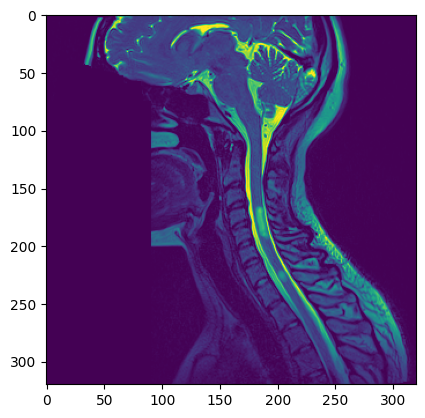

In [217]:
for label_path in glob("./sample/images/sub-nwu06/T2w_sagittal/*.png"):
    image = np.expand_dims(np.array(Image.open(label_path)), 2)
    if len(image.shape) > 3:
        print(image.shape)
        plt.imshow(image[:,:,:,0])
        Image.fromarray(image[:,:,:,0].squeeze()).save(label_path)


In [214]:
from glob import glob 
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
from lesion_augmentor import apply_ms_lesion_augmentation

for label_path in glob("./sample/labels/sub-nwu06/*/*.png"):
    image_path = label_path.replace("labels","images")
    image = np.expand_dims(np.array(Image.open(image_path)), 2)
    spinal_cord_mask = np.expand_dims(np.array(Image.open(label_path)), 2)
    image, spinal_cord_mask = apply_ms_lesion_augmentation(image, spinal_cord_mask)
    print(image.shape)
    Image.fromarray(image.squeeze()).save(image_path)
    


(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
(320, 320, 1)
